# Sparse Vision Transformers with xformers

In this notebook, we will illustrate how one can use the functionality available in xformers to
quickly adapt an already existing Vision Transformer to use xformers efficient sparse kernels.

In this notebook, you'll see:
- how to get **memory and speed improvements** on a standard ViT model by using xformers with 80% sparsity
- how to scale up a standard ViT model so that it can handle sequence **lengths larger than 10k**

Let's start with a few imports. In this notebook, we will be using the `VisionTransformer` from timm

In [1]:
import matplotlib.pyplot as plt
import copy
import torch
from torch import nn
from torch.utils import benchmark

import xformers.components.attention.attention_patterns as AP
from xformers.components.attention.core import scaled_dot_product_attention
from xformers.components.attention._sputnik_sparse import SparseCS

import timm
from timm.models.vision_transformer import VisionTransformer

%matplotlib inline

To facilitate benchmarking and memory profiling, let's define a function that takes a generic callable and executes it, measuring the execution time and the GPU memory

In [2]:
def profile_model(fn, min_run_time=2):
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    res = benchmark.Timer(
        stmt='fn()',
        globals={"fn": fn},
        label="profile",
        sub_label="",
        description=""
    ).blocked_autorange(min_run_time=min_run_time)
    torch.cuda.synchronize()
    memory = torch.cuda.max_memory_allocated() / 2 ** 20
    memory = f"Memory used: {memory} MB"
    print(res)
    print(memory)

Now it comes the core of it. We will implement an `Attention` module following the same API and modules as timm's, but using our `scaled_dot_product_attention` function.
It is worth noting that the `scaled_dot_product_attention` from xformers supports both dense and sparse tensors with the same API, so it can be a drop-in replacement
for experimenting with both sparse and dense attention.

Internally, `scaled_dot_product_attention` will dispatch to the sparse variants if the `attn_mask` is sparse, otherwise it will dispatch to the dense implementation.

We provide support for both COO-sparse matrices (via PyTorch `sparse_coo_tensor`) and CSR matrices (via our custom implementation).
The CSR implementation is significantly faster and should be preferred at pretty-much all times.

In [3]:
# almost drop-in replacement for timm attention
# but using the sparsity-aware scaled_dot_product_attention from xformers
class Attention(torch.nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        attn_drop=0.0,
        proj_drop=0.0,
        attn_mask=None,
    ):
        super().__init__()
        self.num_heads = num_heads

        self.qkv = torch.nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = torch.nn.Dropout(attn_drop)
        self.proj = torch.nn.Linear(dim, dim)
        self.proj_drop = torch.nn.Dropout(proj_drop)
        self.attn_mask = attn_mask

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )

        qkv = qkv.flatten(1, 2)

        q, k, v = qkv.unbind()

        x = scaled_dot_product_attention(q, k, v, self.attn_mask, dropout=self.attn_drop)
        x = x.reshape(B, self.num_heads, N, C // self.num_heads)

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

Let's write a function that given a model, will replace all instances of `timm.models.vision_transformer.Attention` with our own implementation, which leverages `scaled_dot_product_attention` from xformers

In [4]:
def replace_attn_with_xformers_one(module, att_mask):
    module_output = module
    if isinstance(module, timm.models.vision_transformer.Attention):
        qkv = module.qkv
        dim = qkv.weight.shape[1] * module.num_heads
        module_output = Attention(dim, module.num_heads, attn_mask=att_mask)
    for name, child in module.named_children():
        module_output.add_module(name, replace_attn_with_xformers_one(child, att_mask))
    del module
    return module_output

Now it's time to create our Vision Transformer. Nothing unusual here. Note that we will be keeping a copy of the model, which will be the model to use sparse self-attention

In [5]:
img_size = 224
patch_size = 16

model = VisionTransformer(img_size=img_size, patch_size=patch_size,
                              embed_dim=96, depth=8, num_heads=8, mlp_ratio=3.,
                              qkv_bias=False, norm_layer=nn.LayerNorm).cuda()

model_sparse = copy.deepcopy(model)

What comes next is about creating a sparsity pattern that we will be using for our model.

You can refer to the `2d_attention` tutorial for further information on how to build custom attention patterns with xformers

Sequence length: 14x14 = 196
Sparsity: 0.8061789721250534, nnz=1152


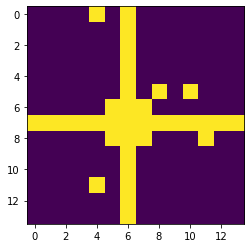

In [6]:
H, W = img_size // patch_size, img_size // patch_size
print(f"Sequence length: {H}x{W} = {H * W}")

axial_pattern = AP.axial_2d_pattern(H, W)
loc_2d_dist = AP.local_2d_pattern(H, W, distance=2, p=2.0)
rand_pattern = torch.rand((H * W) ** 2).reshape(H * W, H * W) > 0.99

gaus_2d_dist = AP.local_2d_gausian_distribution(H, W, sigma=5)
sparsity = 0.97
num_non_zeros = int((H * W) ** 2 * (1 - sparsity))
random_gaus_2d_pattern = AP.random_pattern_from_probability_matrix(gaus_2d_dist, num_non_zeros)


t_mask = axial_pattern | loc_2d_dist | rand_pattern | random_gaus_2d_pattern

# and let's not forget to add a global attention for the cls_token
mask = torch.ones((H * W + 1, H * W + 1), dtype=torch.bool)
mask[1:, 1:] = t_mask

print(f"Sparsity: {1 - mask.float().mean().item()}, nnz={num_non_zeros}")

plt.imshow(mask[H * W // 2 + W // 2][1:].reshape(H, W))
plt.show()

From the print just above, we can see that the full `attn_mask` has a sparsity level of around 80%.

Once we are happy with the sparsity pattern, the next step is to create the sparse matrix that holds our sparsity pattern.

Everything is handled by `SparseCS` class.

**Note: the optimized kernels require that the total number of nonzero elements in the full `attn_mask` to be a multiple of 4. This is handled by default in the implementation (by removing elements until the number of non zeros is a multiple of 4)**

In [7]:
mask = SparseCS(mask, torch.device("cuda"))
print(1 - mask.values.shape[1] / (mask.shape[0] * mask.shape[1]))

0.8061789791027855


Now we are ready to replace the dense attentions with with sparse versions which leverage the sparsity pattern that we have just created

In [8]:
model_sparse = replace_attn_with_xformers_one(model_sparse, mask)

Let's new create an input tensor and benchmark both the sparse and the dense versions

In [9]:
i = torch.rand(64, 3, img_size, img_size).cuda()

## Profiling the default (dense) model

In [10]:
print("Forward only")
profile_model(lambda : model(i))
print("")
print("Forward + backward")
profile_model(lambda : model(i).sum().backward())

Forward only
profile
  Median: 22.70 ms
  IQR:    0.09 ms (22.68 to 22.77)
  88 measurements, 1 runs per measurement, 1 thread
Memory used: 1790.81689453125 MB

Forward + backward
profile
  Median: 77.05 ms
  3 measurements, 10 runs per measurement, 1 thread
Memory used: 1975.78173828125 MB


## Profiling the sparsity-aware model

In [11]:
print("Forward only")
profile_model(lambda : model_sparse(i))
print("")
print("Forward + backward")
profile_model(lambda : model_sparse(i).sum().backward())

Forward only
profile
  Median: 16.38 ms
  IQR:    0.05 ms (16.37 to 16.42)
  13 measurements, 10 runs per measurement, 1 thread
Memory used: 822.93701171875 MB

Forward + backward
profile
  Median: 53.41 ms
  IQR:    0.01 ms (53.40 to 53.41)
  4 measurements, 10 runs per measurement, 1 thread
Memory used: 835.51025390625 MB


This shows that not only the sparse model is ~30% faster, but it also uses less than half the memory compared to the dense counterpart. Great!

# Scaling ViT to sequence lengths of size larger than 10k

Getting speed-ups for training / inference on standard workloads thanks to sparsity is nice, but by leveraging the memory savings from sparse computations we can actually easily scale up ViT to sequence lengths which are much larger than what was originally possible.

Let's get back to the original model, but this time scale it up so that the sequence length is `112 x 112`, and use a 99.5% sparsity pattern.

In [12]:
img_size = 224
patch_size = 2

model_sparse = VisionTransformer(img_size=img_size, patch_size=patch_size,
                              embed_dim=96, depth=8, num_heads=8, mlp_ratio=3.,
                              qkv_bias=False, norm_layer=nn.LayerNorm).cuda()

Everything was the same as before, with the difference that the patch size is now `2x2`, which means that the sequence length is `112x112`, which is much larger than what has been used so far.

Let's create a sparsity pattern to have roughly 99.5% sparsity

Sequence length: 112x112 = 12544
Sparsity: 0.9938480411656201, nnz=786759


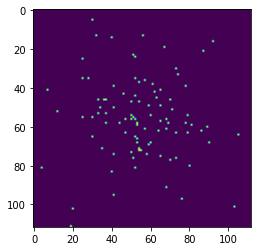

In [13]:
H, W = img_size // patch_size, img_size // patch_size
print(f"Sequence length: {H}x{W} = {H * W}")

rand_pattern = torch.rand((H * W) ** 2).reshape(H * W, H * W) > 0.999

gaus_2d_dist = AP.local_2d_gausian_distribution(H, W, sigma=16)
sparsity = 0.995
num_non_zeros = int((H * W) ** 2 * (1 - sparsity))
random_gaus_2d_pattern = AP.random_pattern_from_probability_matrix(gaus_2d_dist, num_non_zeros)

t_mask = rand_pattern | random_gaus_2d_pattern

# and let's not forget to add a global attention for the cls_token
mask = torch.ones((H * W + 1, H * W + 1), dtype=torch.bool)
mask[1:, 1:] = t_mask

print(f"Sparsity: {1 - mask.float().mean().item()}, nnz={num_non_zeros}")

plt.imshow(mask[H * W // 2 + W // 2][1:].reshape(H, W))
plt.show()

mask = SparseCS(mask, torch.device("cuda"))

And now, as before, replace the dense attentions with the sparse ones

In [14]:
model_sparse = replace_attn_with_xformers_one(model_sparse, mask)

Now create a random input and let's feed it to our model and benchmark

In [15]:
i = torch.rand(8, 3, img_size, img_size).cuda()

In [16]:
print("Forward only")
profile_model(lambda : model_sparse(i))
print("")
print("Forward + backward")
profile_model(lambda : model_sparse(i).sum().backward())

Forward only
profile
  Median: 194.43 ms
  IQR:    0.94 ms (193.73 to 194.67)
  11 measurements, 1 runs per measurement, 1 thread
Memory used: 8022.40283203125 MB

Forward + backward
profile
  Median: 633.81 ms
  IQR:    3.66 ms (632.41 to 636.07)
  4 measurements, 1 runs per measurement, 1 thread
Memory used: 8207.640625 MB


By using a very sparse matrix for the self-attention computation, we were able to run ViT with sequence length of 10k by using ~8GB of GPU memory for a batch size of 8.
The speed / memory can be easily tuned by controlling the degree of sparsity of your `attn_mask`.

# Wrapping up

In this notebook, we've show one way of quickly getting started with using xformers in your codebase.
We showed how to get both memory and speed savings by leveraging sparse computations, and we also showed that it is possible to runa full forward+backward on a ViT model whose sequence length is greater than 10k.

We hope that xformers can enable new research directions on very large sequences.

If you have questions, we will be happy to help you getting started with xformers!